In [1]:
# Import libraries and set up Duffing class

%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class Duffing():
    """
    Duffing class implements the parameters and differential equation for 
    an approximated pendulum, using the first two nonzero terms in the taylor series
    for sine(x).
     
    Parameters
    ----------
    delta : float
        the damping coefficient in front of x_dot
    alpha: float
        the new "natural frequency" of the oscillator
    beta : float
        the coefficient in front of the x^3 term
    gamma_ext : float
        amplitude of external force, with units N/kg
    omega_ext : float
        frequency of external force 
    phi_ext : float
        phase angle for external force 

    Methods
    -------
    dy_dt(y, t)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    driving_force(t) 
        Returns the value of the external driving force at time t.
    solve_ode(x_0, x_dot_0, t_pts, abserr, relerr)
        Returns x and x_dot for all times 
    """
    def __init__(self, delta=0.3, alpha=-1., beta=1., gamma_ext=0.2, omega_ext=1.2, phi_ext=0.):
        self.delta = delta
        self.alpha = alpha
        self.beta = beta
        self.gamma_ext = gamma_ext
        self.omega_ext = omega_ext
        self.phi_ext = phi_ext
    
    def dy_dt(self, y, t):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        y : float
            A 2-component vector with y[0] = x(t) and y[1] = dx/dt
        t : float
            time 
            
        Returns
        -------
        y : list of floats
            [dphi/dt, d^2phi/dt^2]
        """
        F_ext = self.driving_force(t)
        return [y[1], -self.delta*y[1] - self.alpha*y[0] - self.beta*(y[0]**3) + F_ext]
        # Old return: [y[1],-self.omega_0**2 * np.sin(y[0]) - 2.*self.beta * y[1] + F_ext]
    
    def driving_force(self, t):
        """
        This function returns the value of the driving force at time t.
        """
        return self.gamma_ext * np.cos(self.omega_ext*t + self.phi_ext)  
    
    def solve_ode(self, x_0, x_dot_0, t_pts, abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x_0, x_dot_0]  
        x, x_dot = odeint(self.dy_dt, y, t_pts, 
                              atol=abserr, rtol=relerr).T
        return x, x_dot
    
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None, square=False, ratio=1.):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])
        
    if (square):
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        # the abs method is used to make sure that all numbers are positive
        # because x and y axis of an axes maybe inversed.
        ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    
    
    return ax, line

def start_stop_indices(t_pts, plot_start, plot_stop):
    """Given an array (e.g., of times) and desired starting and stop values,
        return the array indices that are closest to those values.
    """
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [2]:
# Create two functions for plotting and generating tables

def Plots_and_Calc(t_pts, delta=0.3, alpha=-1., beta=1., gamma_ext=[0.2, 0.29, 0.65], \
                     omega_ext=1.2, x_0=1., x_dot_0=0.):
    # Additional parameters
    # We need a set of t_pts that are calibrated as t/T for plotting purposes
    T = 2.*np.pi / omega_ext

    # We also need start and stop points for both plots
    XvT_start = 19.
    XvT_stop = 38.
    XdotvX_start=19.
    XdotvX_stop=100.

    # Get the length of gama_ext to know how many iterations in the loop need to be done.
    numGamma = len(gamma_ext)
    
    # We also need to initialize a list that will hold all of the data values for various periods and gammas
    tableDat =[]

    # Labels for individual plot axes
    x_vs_time_labels = (r'$t/T$', r'$x(t)$')
    x_dot_vs_time_labels = (r'$t/T$', r'$dx/dt(t)$')
    state_space_labels = (r'$x$', r'$dx/dt$')

    # start the plot!
    fig = plt.figure(figsize=(18, 24))
    overall_title = 'Taylor Ch. 12:  ' + \
                    rf' $\delta = {delta:.1f},$' + \
                    rf' $\alpha = {alpha:.1f},$' + \
                    rf' $\beta = {beta:.1f},$' + \
                    rf' $\gamma = {gamma_ext[0]:.2}-{gamma_ext[-1]:.2f},$' + \
                    rf' $\omega_ext = {omega_ext:.1f},$' + \
                    rf'  $x_0 = {x_0:.1f},$' + \
                    rf' $\dotx_0 = {x_dot_0:.1f}$' + \
                    '\n'     # \n means a new line (adds some space here)
    fig.suptitle(overall_title, va='baseline')

    for g in range(numGamma):
        """Instantiate a pendulum. The duffing eq. doesn't include a phi_ext, but I included it 
        in my pendulumn class. So here, I define it to be zero."""
        p = Duffing(delta=delta, alpha=alpha, beta=beta, gamma_ext=gamma_ext[g], 
                     omega_ext=omega_ext, phi_ext=0)

        # calculate the driving force for t_pts
        driving = p.driving_force(t_pts)

        # initial conditions specified
        x, x_dot = p.solve_ode(x_0, x_dot_0, t_pts)

        # Change the common font size
        font_size = 14
        plt.rcParams.update({'font.size': font_size})

        # Plot X vs t
        ax_a = fig.add_subplot(numGamma,2, 2*g+1)                  
        start, stop = start_stop_indices(t_pts, XvT_start*T, XvT_stop*T)
        plot_y_vs_x(t_pts[start : stop]/T, x[start : stop], 
                    axis_labels=x_vs_time_labels, 
                    color='blue',
                    label=None, 
                    title=rf'$\gamma={gamma_ext[g]:.2f}$, t: ${XvT_start:.1f}-{XvT_stop:.1f}$', 
                    ax=ax_a)
        
        # Plot Xdot vs X
        ax_a = fig.add_subplot(numGamma,2, 2*g+2)
        start, stop = start_stop_indices(t_pts, XdotvX_start*T, XdotvX_stop*T)
        plot_y_vs_x(x[start : stop], x_dot[start : stop], 
                    axis_labels=state_space_labels, 
                    color='blue',
                    label=None, 
                    title=rf'$\gamma={gamma_ext[g]:.2f}$, t: ${XdotvX_start:.1f}-{XdotvX_stop:.1f}$', 
                    ax=ax_a, square=True, ratio=1.)
        
        # Store data for table
        indexDat = []
        for i in range(19):
            index = (np.fabs(t_pts-(19+i)*T)).argmin()
            indexDat.append(index)
        tableDat.append([x[i] for i in indexDat])
        
    fig.tight_layout()
    fig.savefig('Ch12plot1.png', bbox_inches='tight');  # always bbox_inches='tight'
    
    tableDat = np.array(tableDat).T.tolist()
    return tableDat

def Make_Table(tableDat, gamma_ext):

    rows = [rf"$t/T={i+19:.1f}$" for i in range(19)]
    columns = [rf"$\gamma={i:.2f}$" for i in gamma_ext]
    
    fig = plt.figure(figsize=(15,30))
    ax = fig.add_subplot(1,1,1)

    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=tableDat,
                              colLabels=columns,
                              rowLabels=rows,
                              loc='center')
    ratio = 2
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    # the abs method is used to make sure that all numbers are positive
    # because x and y axis of an axes maybe inversed.
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    
    plt.show()
    
def Check_Chaotic(t_pts, delta=0.3, alpha=-1., beta=1., gamma_ext=0.50, \
                     omega_ext=1.2, x_0=1., delta_x_0=0.00001, x_dot_0=0.):    
    # Additional parameters
    # We need a set of t_pts that are calibrated as t/T for plotting purposes
    T = 2.*np.pi / omega_ext

    # We also need start and stop points for both plots
    XvT_start = 0.
    XvT_stop = 150.

    # Labels for individual plot axes
    dx_vs_time_labels = (r'$t/T$', r'$\Delta x(t)$')

    # start the plot!
    fig = plt.figure(figsize=(6,6))
    overall_title = 'Taylor Ch. 12:  ' + \
                    rf' $\delta = {delta:.1f},$' + \
                    rf' $\alpha = {alpha:.1f},$' + \
                    rf' $\beta = {beta:.1f},$' + \
                    rf' $\gamma = {gamma_ext:.2f},$' + \
                    rf' $\omega_ext = {omega_ext:.1f},$' + \
                    rf'  $x_0 = {x_0:.1f},$' + \
                    rf' $\dotx_0 = {x_dot_0:.1f}$' + \
                    '\n'     # \n means a new line (adds some space here)
    fig.suptitle(overall_title, va='baseline')


    """Instantiate a pendulum. The duffing eq. doesn't include a phi_ext, but I included it 
    in my pendulumn class. So here, I define it to be zero."""
    p = Duffing(delta=delta, alpha=alpha, beta=beta, gamma_ext=gamma_ext, 
                     omega_ext=omega_ext, phi_ext=0)

    # initial conditions specified
    x1, x_dot1 = p.solve_ode(x_0, x_dot_0, t_pts)
    x2, x_dot2 = p.solve_ode(x_0+delta_x_0, x_dot_0, t_pts)
    dx = np.abs(x1 - x2)
    # Change the common font size
    font_size = 14
    plt.rcParams.update({'font.size': font_size})
    # Plot X vs t
    ax_a = fig.add_subplot(1,1,1)                  
    start, stop = start_stop_indices(t_pts, XvT_start*T, XvT_stop*T)
    plot_y_vs_x(t_pts[start : stop]/T, dx[start : stop], 
                axis_labels=dx_vs_time_labels, 
                color='blue',
                semilogy=True,
                label=None, 
                title=rf'$\gamma={gamma_ext:.2f}$, t: ${XvT_start:.1f}-{XvT_stop:.1f}$', 
                ax=ax_a)
    
    fig.tight_layout()
    #fig.savefig('Ch12plot2.png', bbox_inches='tight');  # always bbox_inches='tight'

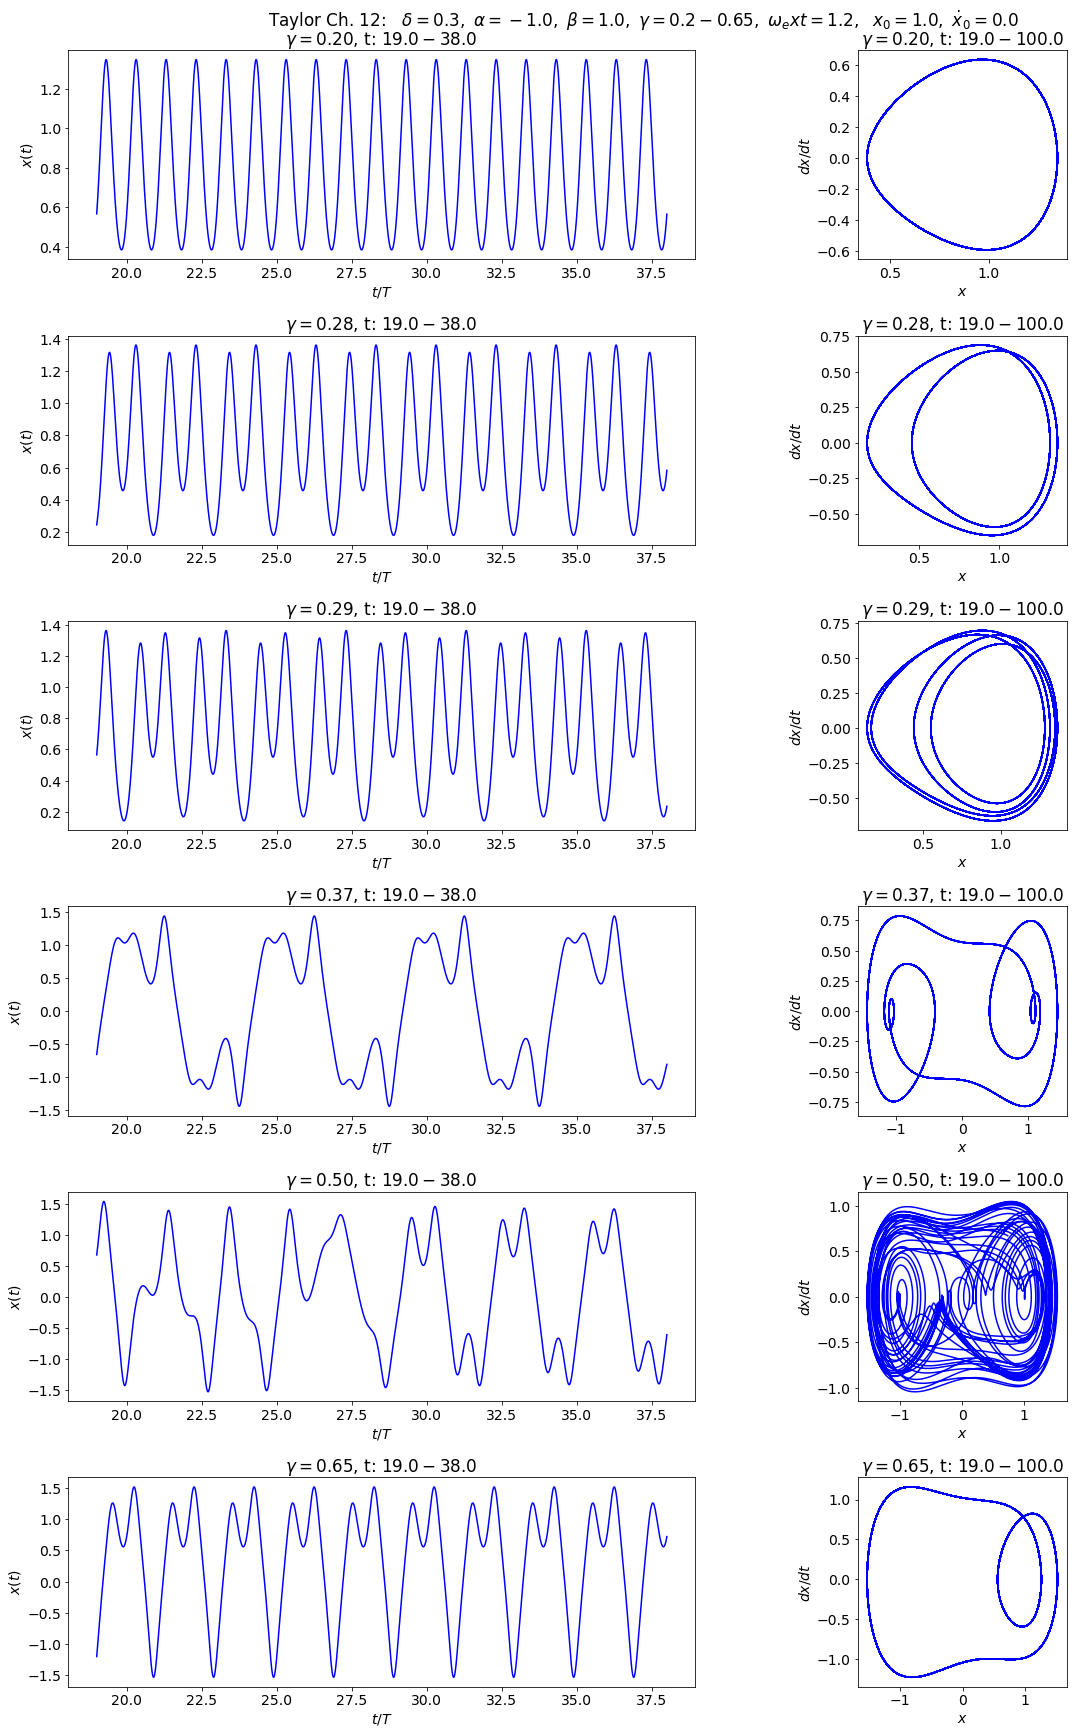

In [6]:
# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 400.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

tableDat = Plots_and_Calc(delta=0.3, alpha=-1., beta=1., gamma_ext=[0.2,0.28, 0.29, 0.37,0.50, 0.65], 
                     omega_ext=1.2, x_0=1., x_dot_0=0., t_pts=t_pts)



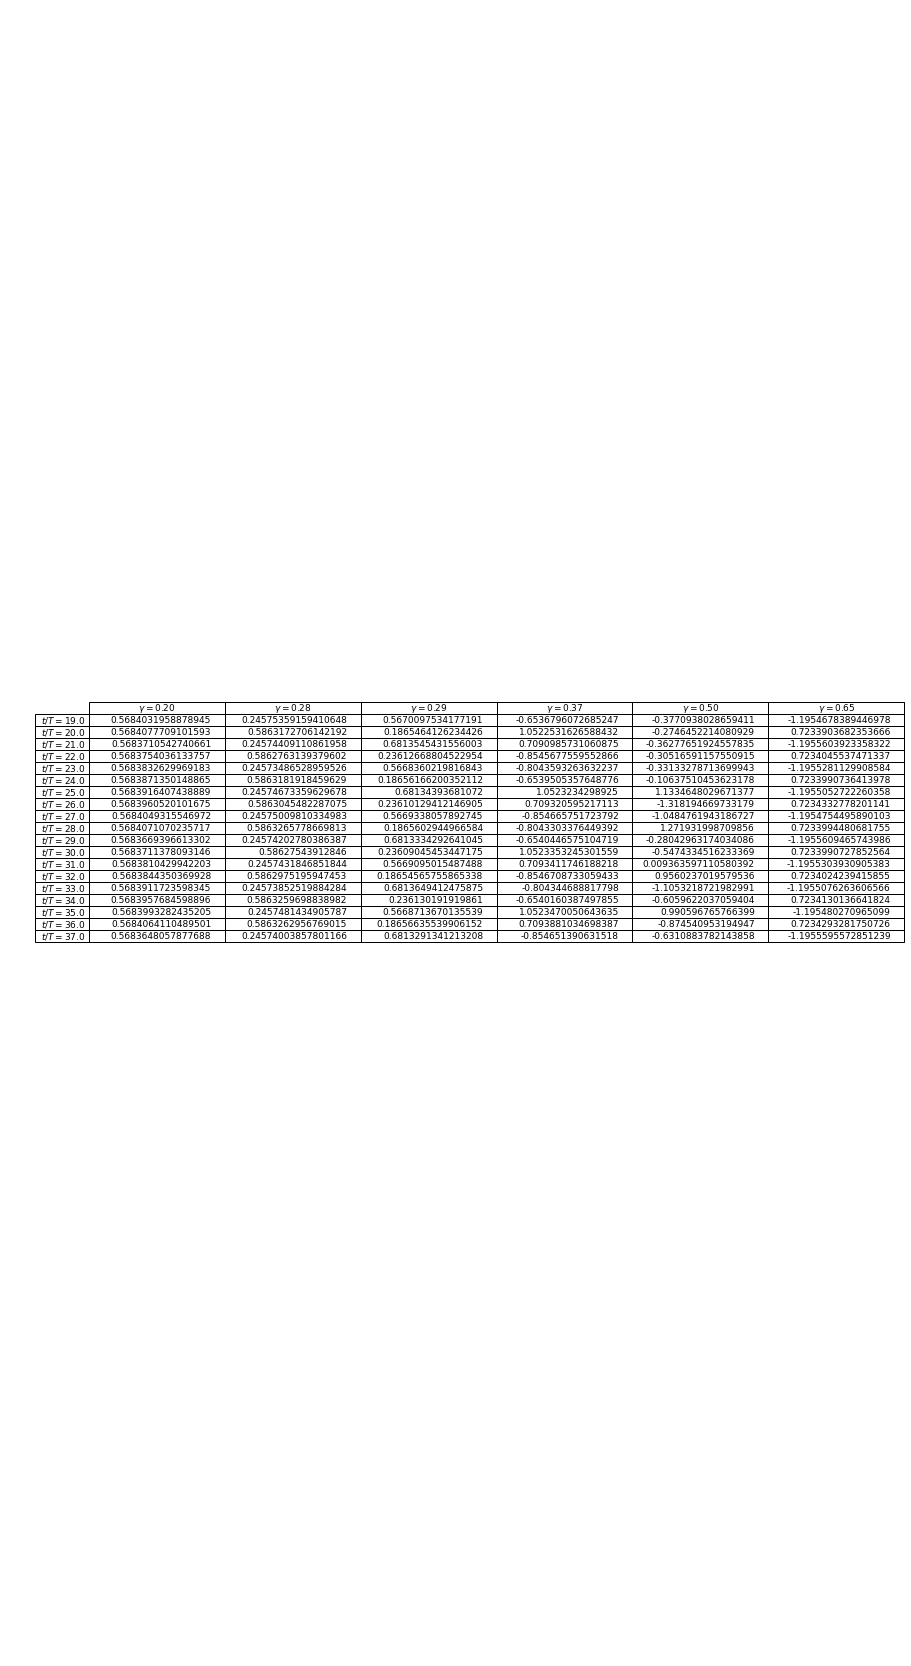

In [6]:
Make_Table(tableDat, gamma_ext=[0.2,0.28, 0.29, 0.37,0.50, 0.65])

In [ ]:
Check_Chaotic(t_pts)